# PyPRT - Building Modeling Optimization

In this notebook, we are using a CGA rule that allows us to generate modern and sustainable buildings. The architecture of these buildings is focused on the green aspect of the building. Therefore, in addition to be modern and esthetical, the generated building answers also to the actual requirements of the city which are to encourage the integration of greenery on the buildings.

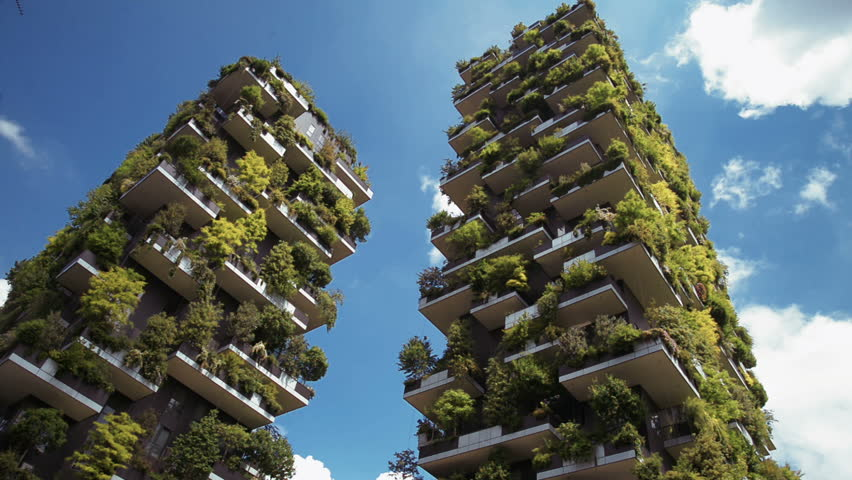

Bosco Verticale in Milan

#### Imports

In [1]:
import sys
import os
from scipy import optimize
import numpy as np
from PyGEL3D import gel, js

In [2]:
import pyprt
pyprt.initialize_prt()

if(not pyprt.is_prt_initialized()):
    raise Exception("PRT is not initialized")

[PRT] [2020-02-20 11:43:54] [error] failed to load library: error while loading library 'c:\users\cami9495\documents\esri-cityengine-sdk-master\examples\py4prt\pyprt\pyprt\lib\com.esri.prt.unreal.dll': The specified module could not be found.

[PRT] [2020-02-20 11:43:54] [error] failed to load library: error while loading library 'c:\users\cami9495\documents\esri-cityengine-sdk-master\examples\py4prt\pyprt\pyprt\lib\DatasmithSDK.dll': The specified module could not be found.



## Optimization Problem Definition

Given the architectural design of this building (defined by the CGA rule) and the parcel, which value of the **lot coverage**, **tier height** and **building shape** should we choose in order to maximize the building green potential (green area).

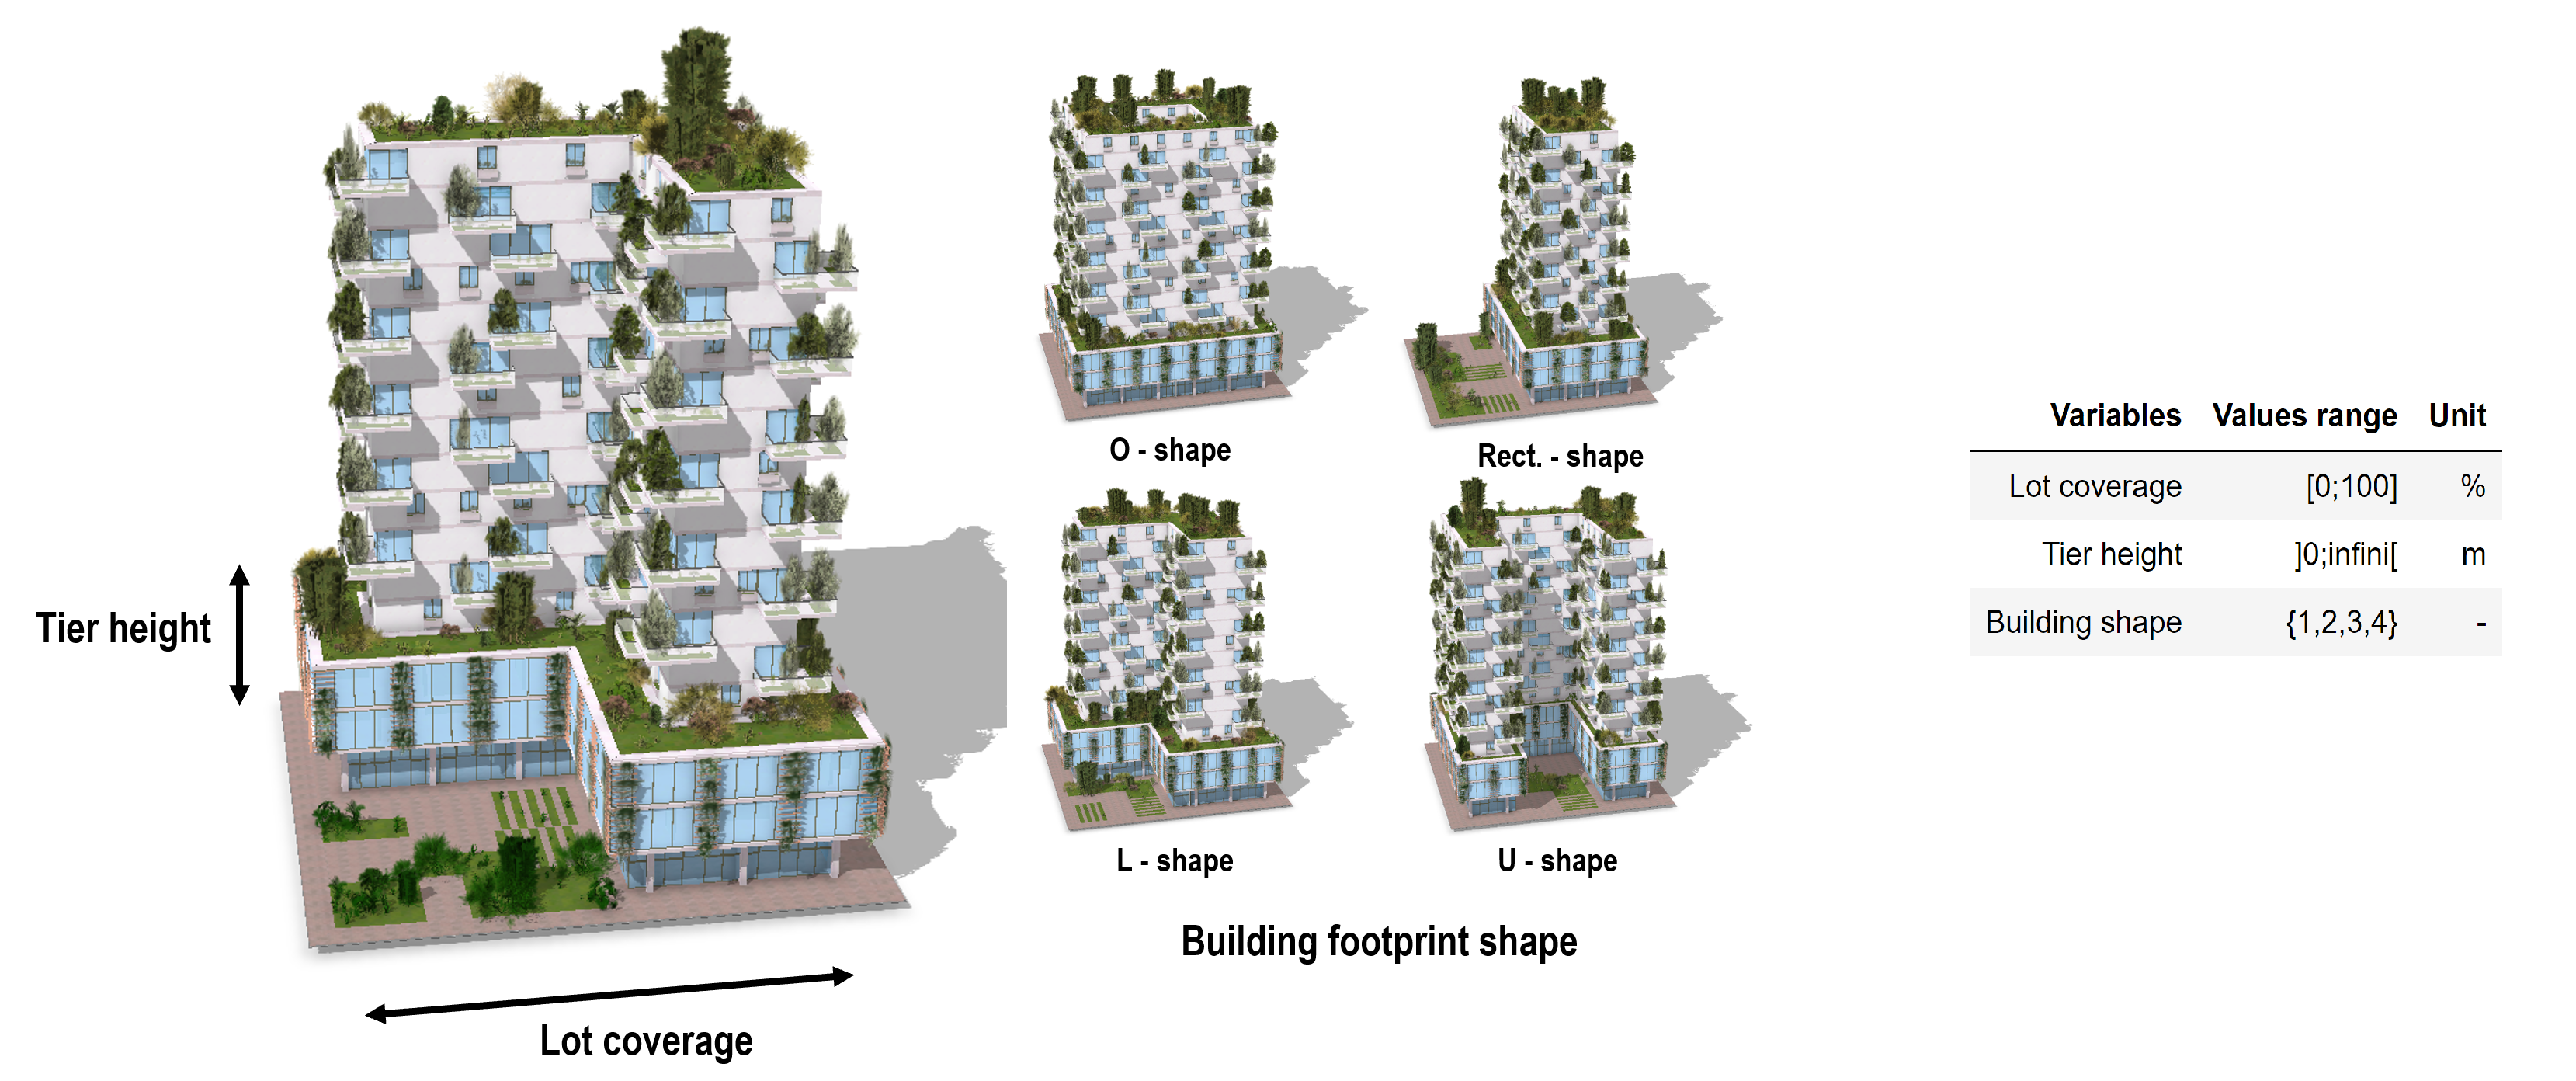

In this example, only the previously mentioned variables were taken into account for simplicity purposes. For instance, the building parcel geographical orientation is not known. Therefore, the sun direction could not be derived. The well-being of the plants and greenery is thus not considered.

### Given: building architecture (CGA Rule Package) and parcel to redevelop

In [3]:
rpk_green = os.path.join(os.getcwd(), 'data', 'envelope2002.rpk')
attrs_green = {'ruleFile': 'rules/typology/envelope2002.cgb',
               'startRule': 'Default$Lot', 'report_but_not_display_green': True}
shape_geo = pyprt.InitialShape(os.path.join(
    os.getcwd(), 'data', 'building_parcel.obj'))

### Greenery Optimization

Step 1 : optimize the total green area reported (including the balconies trees). This will be optimized taking into account several parameters:
- the shape of the building (1 = orthogonal, 2 = L shape, 3 = U shape, 4 = O shapes)
- the lot coverage
- the height of the first tier

#### Optimization Variables

In [4]:
goal_str_green = 'Greenery Area' + '_sum'

input_attr_green = ['lot_coverage_parameter',
                    'height_first_tier', 'shape_of_building']
x0_green = [float(50), float(9), float(round(2))]

In [5]:
m = pyprt.ModelGenerator([shape_geo])
model = m.generate_model([attrs_green], rpk_green,
                         'com.esri.pyprt.PyEncoder', {'emitGeometry': False})

In [6]:
def fct_green(x):

    attrs_green[input_attr_green[0]] = x[0]
    attrs_green[input_attr_green[1]] = x[1]
    attrs_green[input_attr_green[2]] = float(round(x[2]))
    generated_mod_green = m.generate_model([attrs_green])

    if generated_mod_green:
        rep_green = generated_mod_green[0].get_report()
        return -rep_green[goal_str_green]
    else:
        print('Error in optimization process.')

#### Variables boundaries

In [7]:
bounds_green = [(0, 100), (8, 13), (1, 4)]

The SciPy optimization library is extensively used within Python community. However, **any** optimization algorithm works with PyPRT. In this notebook, the optimization problem to solve is complex and highly non linear. The differential evolution algorithm from SciPy is particularly suited to our problem because it is stochastic and, thus, does not need any gradient computation to find the minimum. The choice of optimization algorithm depends on the problem and, in our case, in the CGA rule.

In [8]:
res_green = optimize.differential_evolution(
    fct_green, bounds_green, tol=0.15, seed=666)
res_green

     fun: -4065.8768645564187
 message: 'Optimization terminated successfully.'
    nfev: 184
     nit: 3
 success: True
       x: array([34.99030757, 11.35376576,  3.69885958])

#### Results Visualization

In [9]:
export_file_name = 'ex7_optimalmodel1'
enc_options = {'baseName': export_file_name,
               'outputPath': os.path.join(os.getcwd(), 'ex7_output')}
os.makedirs(enc_options['outputPath'], exist_ok=True)

attrs_green[input_attr_green[0]] = res_green.x[0]
attrs_green[input_attr_green[1]] = res_green.x[1]
attrs_green[input_attr_green[2]] = float(round(res_green.x[2]))
green_model = m.generate_model(
    [attrs_green], rpk_green, 'com.esri.prt.codecs.OBJEncoder', enc_options)

In [15]:
image = gel.obj_load(os.path.join(
    enc_options['outputPath'], export_file_name+'_0.obj'))
js.display(image, smooth=False)

FigureWidget({
    'data': [{'color': '#dddddd',
              'flatshading': True,
              'i': array([…

The textures are not shown here. Open the OBJ file with another app to see the colorful model. Depending on your needs, a GLTF file could be useful. In this case, export the 3D generated model using the "com.esri.prt.codecs.GLTFEncoder".

## Multi-Objectives Optimization

Step 2 : optimize the green area reported including the balconies trees AND the floor area in order to avoid thin walls. We will keep O-shape building. This will be optimized taking into account several parameters:

- the lot coverage
- the height of the first tier

#### Optimization Variables

In [16]:
goal_str_green = 'Greenery Area' + '_sum'
goal_str_floor = 'Floor area' + '_sum'
# this allows having similar range between the green area and the floor area
floor_weight = 0.07

input_attr_green = ['lot_coverage_parameter', 'height_first_tier']
x0_green = [float(50), float(9)]

In [17]:
attrs_green = {'ruleFile': 'rules/typology/envelope2002.cgb', 'startRule': 'Default$Lot',
               'report_but_not_display_green': True, 'shape_of_building': 4.0}

model2 = m.generate_model([attrs_green], rpk_green,
                          'com.esri.pyprt.PyEncoder', {'emitGeometry': False})

In [18]:
def fct_green(x):

    attrs_green[input_attr_green[0]] = x[0]
    attrs_green[input_attr_green[1]] = x[1]
    generated_mod_green = m.generate_model([attrs_green])

    if generated_mod_green:
        rep_green = generated_mod_green[0].get_report()
        return -(rep_green[goal_str_green]+floor_weight*rep_green[goal_str_floor])
    else:
        print('Error in optimization process.')

In [19]:
bounds_green = [(0, 100), (8, 13)]

In [20]:
res_green = optimize.differential_evolution(
    fct_green, bounds_green, tol=0.1, seed=666)
res_green

     fun: -4702.021447917708
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 2
 success: True
       x: array([60.56927098, 12.64878533])

#### Results Visualization

In [21]:
export_file_name = 'ex7_optimalmodel2'
enc_options['baseName'] = export_file_name

attrs_green[input_attr_green[0]] = res_green.x[0]
attrs_green[input_attr_green[1]] = res_green.x[1]
green_model = m.generate_model(
    [attrs_green], rpk_green, 'com.esri.prt.codecs.OBJEncoder', enc_options)

In [22]:
image = gel.obj_load(os.path.join(
    enc_options['outputPath'], export_file_name+'_0.obj'))
js.display(image, smooth=False)

FigureWidget({
    'data': [{'color': '#dddddd',
              'flatshading': True,
              'i': array([…

In [23]:
pyprt.shutdown_prt()